# GAIA to TESS

In [409]:
import lightkurve as lk
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle

import sys
sys.path
sys.path.append('./dave/diffimg/')
import tessprf as prf
from scipy import interpolate
from scipy import signal

In [96]:
def Get_TESS(RA,DEC,Size,Sector=None):
    c = SkyCoord(ra=float(RA)*u.degree, dec=float(DEC) *
                 u.degree, frame='icrs')
    
    tess = lk.search_tesscut(c,sector=Sector)
    tpf = tess.download(cutout_size=Size)
    
    return tpf

def Downsample(PSconv):
	"""
	Downsamples the PS image to the resolution of TESS.
	Inputs
    ------
    PSconv: array like
    	The PS image convolved with the TESS PSF
	Returns
	-------
	TESS_resolution: array like
		The PS image reduced to the TESS resolution
	"""
	PSpixel = 0.021 # arcseconds per pixel 
	TESSpixel = 21 # arcseconds per pixel 
	Scale = 100#TESSpixel/PSpixel
	xnew = np.arange(PSconv.shape[1]/Scale)
	ynew = np.arange(PSconv.shape[0]/Scale)
	TESS_resolution = np.zeros((int(PSconv.shape[0]/Scale),int(PSconv.shape[1]/Scale)))
	for i in range(len(ynew)-1):
		ystart = int(i*Scale)
		yend = int(ystart + Scale)
		for j in range(len(xnew)-1):
			xstart = int(j*Scale)
			xend = int(xstart + Scale)
			TESS_resolution[i,j] = np.nansum(PSconv[ystart:yend,xstart:xend])
	return TESS_resolution

In [364]:
def Get_PRF(Row,Col,Camera,CCD):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(Col, Row, 1,Camera,CCD)
    #PRF = PRF / np.nansum(PRF)
    return PRF

def Interp_PRF(Row,Col,Camera,CCD):
    pathToMatFile = './data/prf/'
    obj = prf.TessPrf(pathToMatFile)
    PRF = obj.getPrfAtColRow(Col, Row, 1,Camera,CCD)
    norm = np.nansum(PRF)
    x2 = np.arange(0,PRF.shape[1]-1,0.01)
    y2 = np.arange(0,PRF.shape[0]-1,0.01)

    x = np.arange(0,PRF.shape[1],1)
    y = np.arange(0,PRF.shape[0],1)
    X, Y = np.meshgrid(x,y)

    x=X.ravel()              #Flat input into 1d vector
    y=Y.ravel()

    z = PRF
    z = z.ravel()
    x = list(x[np.isfinite(z)])
    y = list(y[np.isfinite(z)])
    z = list(z[np.isfinite(z)])

    znew = interpolate.griddata((x, y), z, (x2[None,:], y2[:,None]), method='cubic')
    kernal = znew
    kernal = kernal * (norm/np.nansum(kernal))
    return kernal

def Gaia(tpf, magnitude_limit = 18):
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    result = Vizier.query_region(c1, catalog=["I/345/gaia2"],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise too_few_found_message
    result = result["I/345/gaia2"].to_pandas()
    
    result = result[result.Gmag < magnitude_limit]
    if len(result) == 0:
        raise no_targets_found_message
    radecs = np.vstack([result['RA_ICRS'], result['DE_ICRS']]).T
    coords = tpf.wcs.all_world2pix(radecs, 0) ## TODO, is origin supposed to be zero or one?
    Gmag = result['Gmag'].values
    #Jmag = result['Jmag']
    ind = (((coords[:,0] >= -0.5*tpf.shape[1]) & (coords[:,1] >= -0.5*tpf.shape[2])) & 
           ((coords[:,0] < 1.5*tpf.shape[1]) & (coords[:,1] < 1.5*tpf.shape[2])))
    coords = coords[ind]
    Gmag = Gmag[ind]
    #Jmag = Jmag[ind]
    return coords, Gmag

def TIC(tpf, magnitude_limit = 18):
    c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
    # Use pixel scale for query size
    pix_scale = 4.0  # arcseconds / pixel for Kepler, default
    if tpf.mission == 'TESS':
        pix_scale = 21.0
    # We are querying with a diameter as the radius, overfilling by 2x.
    from astroquery.vizier import Vizier
    Vizier.ROW_LIMIT = -1
    result = Vizier.query_region(c1, catalog=["TIC"],
                                 radius=Angle(np.max(tpf.shape[1:]) * pix_scale, "arcsec"))
    no_targets_found_message = ValueError('Either no sources were found in the query region '
                                          'or Vizier is unavailable')
    too_few_found_message = ValueError('No sources found brighter than {:0.1f}'.format(magnitude_limit))
    if result is None:
        raise no_targets_found_message
    elif len(result) == 0:
        raise too_few_found_message
    result = result["I/197A/tic"].to_pandas()
    
    result = result[result.Vmag < magnitude_limit]
    if len(result) == 0:
        raise no_targets_found_message
    radecs = np.vstack([result['RAJ2000'], result['DEJ2000']]).T
    coords = tpf.wcs.all_world2pix(radecs, 0) ## TODO, is origin supposed to be zero or one?
    Gmag = result['Vmag'].values
    #Jmag = result['Jmag']
    ind = (((coords[:,0] >= -0.5*tpf.shape[1]) & (coords[:,1] >= -0.5*tpf.shape[2])) & 
           ((coords[:,0] < 1.5*tpf.shape[1]) & (coords[:,1] < 1.5*tpf.shape[2])))
    coords = coords[ind]
    Gmag = Gmag[ind]
    #Jmag = Jmag[ind]
    return coords, Gmag

In [155]:
from astroquery.vizier import Vizier
Vizier.ROW_LIMIT = -1
c1 = SkyCoord(tpf.ra, tpf.dec, frame='icrs', unit='deg')
result = Vizier.query_region(c1, catalog=["TIC"],
                                 radius=Angle(np.max(tpf.shape[1:]) * 24, "arcsec"))

result = result["I/197A/tic"].to_pandas()

In [156]:
result

,TICID1,TICID2,RAJ2000,DEJ2000,ePos,e_Bmag,Bmag,e_Vmag,Vmag,Flag1
0,3611,1156,b'22 23 36.769',b'+47 04 02.38',23,NaN,NaN,0.40,11.4,0
1,3611,1182,b'22 24 06.759',b'+47 05 21.50',22,NaN,NaN,0.40,11.5,0
2,3611,1484,b'22 24 34.209',b'+46 54 59.59',22,NaN,NaN,0.40,11.4,0
3,3611,1532,b'22 24 37.500',b'+46 55 19.25',23,NaN,NaN,0.01,11.9,0
4,3611,1548,b'22 23 39.729',b'+46 59 28.79',33,NaN,NaN,0.40,11.1,0
5,3611,1669,b'22 24 01.319',b'+47 00 18.68',32,NaN,NaN,0.50,9.0,0
6,3611,2032,b'22 24 37.437',b'+46 57 55.68',23,NaN,NaN,0.01,12.1,0
7,3611,2148,b'22 24 27.839',b'+46 56 26.29',24,NaN,NaN,0.40,10.6,0


In [152]:
result

TableList with 1 tables:
	'0:I/197A/tic' with 10 column(s) and 1 row(s) 

In [171]:
tpf = Get_TESS(30.26933,24.50988,20)

In [164]:
TIC(tpf)

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [172]:
pos, gmag = Gaia(tpf)

<IPython.core.display.Javascript object>


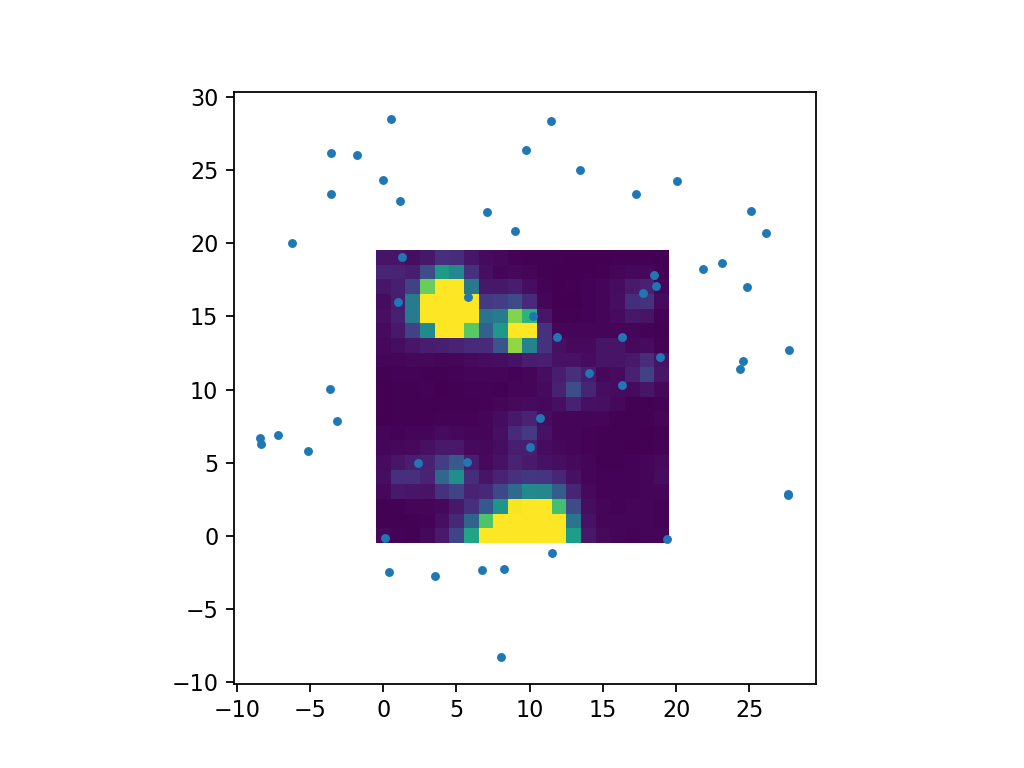

In [174]:
plt.figure()
plt.imshow(tpf.flux[100],origin='lower',vmax = 500)
plt.plot(pos[:,0],pos[:,1],'.')

In [423]:
def GAIA_scene(Ra,Dec,Size,Maglim=19):
    tpf = Get_TESS(Ra,Dec,Size)
    pos, gmag = Gaia(tpf,magnitude_limit=Maglim)
    pos -= 1
    Tmag = gmag - 0.5
    tcounts = 10**(-2/5*(Tmag - 20.44))
    sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2]))
    for i in range(len(pos)):
        template = np.zeros((2*tpf.shape[1]*100,2*tpf.shape[2]*100))
        kernal = Interp_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd) # check row and column are right
        #print(template.shape)
        offset1 = int(0.5 * tpf.shape[1] * 100)
        offset2 = int(0.5 * tpf.shape[2] * 100)
        template[int(pos[i,0]*100 + offset1),int(pos[i,1]*100+ offset2)] = tcounts[i]
        template = signal.fftconvolve(template, kernal, mode='same')
        template = template[offset1:int(3*offset1+1),offset2:int(3*offset2+1)]
        sources[i] = Downsample(template)
    return sources 

In [421]:
test = GAIA_scene(336,60,20,Maglim=14,Interpolate=True)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:202: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)
(4000, 4000)


In [114]:
from scipy.ndimage import  rotate
from astropy.visualization import (SqrtStretch, ImageNormalize)

In [417]:
tpf = Get_TESS(336,60,20)

/Users/ryanr/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:202: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


<IPython.core.display.Javascript object>


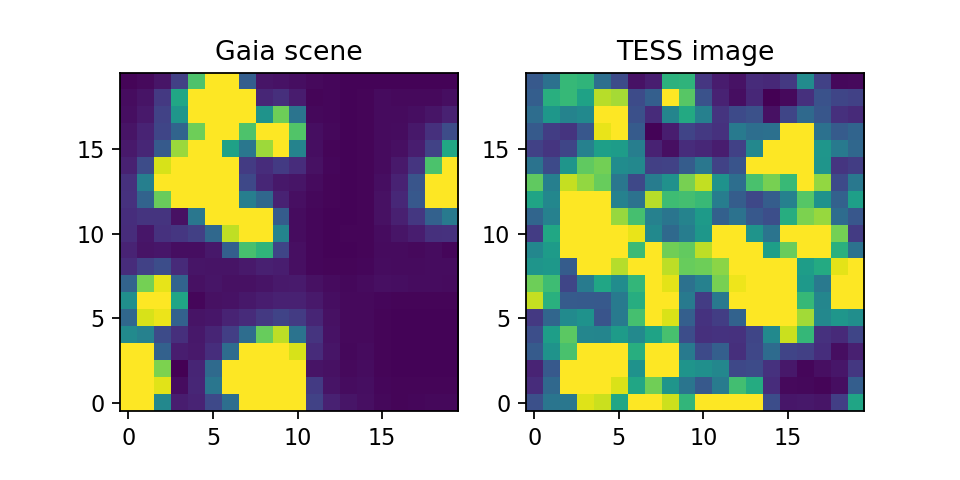

In [422]:
gaia = np.nansum(test,axis=0)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(gaia/np.nanmax(gaia),origin='lower',vmax = .05)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[100]/np.nanmax(tpf.flux[100]),origin='lower',vmax = .11)
plt.savefig('gaia_scene.png')

<IPython.core.display.Javascript object>


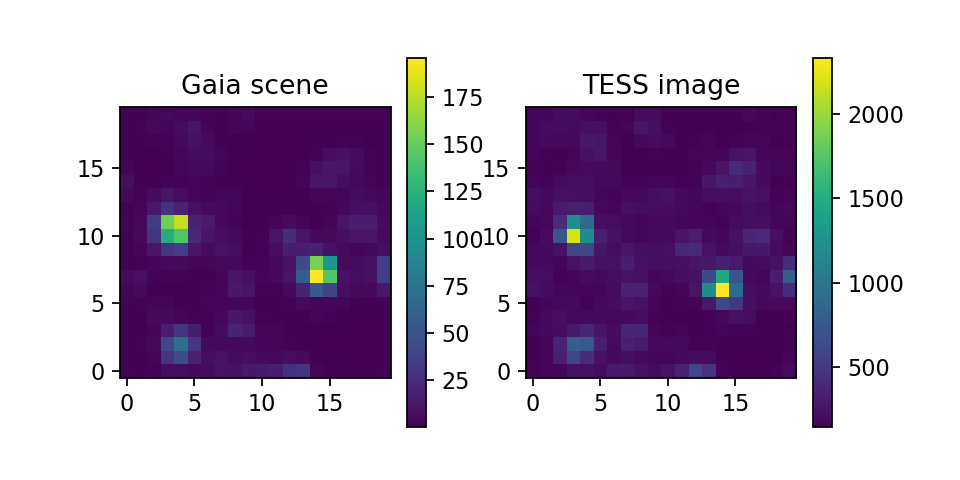

In [190]:
gaia = np.nansum(test,axis=0)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(rotate(np.flipud(gaia),-90),origin='lower')
plt.colorbar()
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[0],origin='lower')
plt.colorbar()


#plt.savefig('gaia_scene.png')


In [192]:
tpf.shape

(1118, 20, 20)

In [196]:
allsum = np.nansum(tpf.flux,axis=(1,2))

In [202]:
ind = np.percentile(allsum,5) >  allsum  

<IPython.core.display.Javascript object>


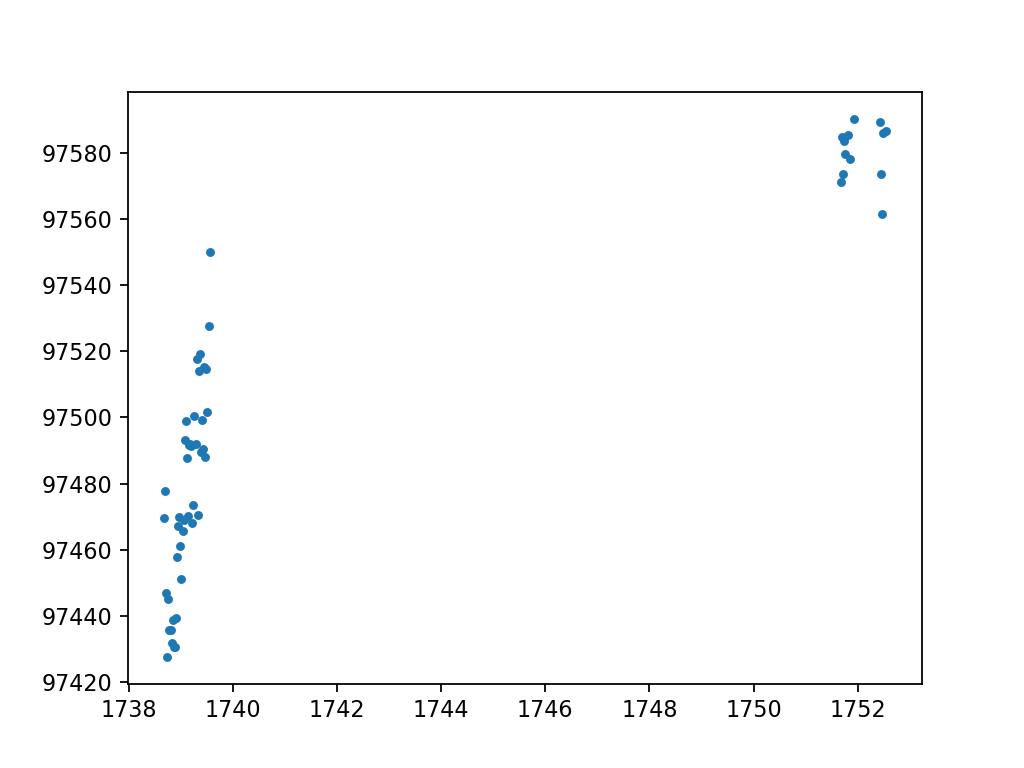

In [203]:
plt.figure()
plt.plot(tpf.time[ind],np.nansum(tpf.flux[ind],axis=(1,2)),'.')

# Minimal case: isolated star

In [344]:
# HD 44958
ra =  95.4586
dec = -51.2377
# another HD
ra = 58.7404
dec = 12.9061
tpf = Get_TESS(ra,dec,20)

<IPython.core.display.Javascript object>


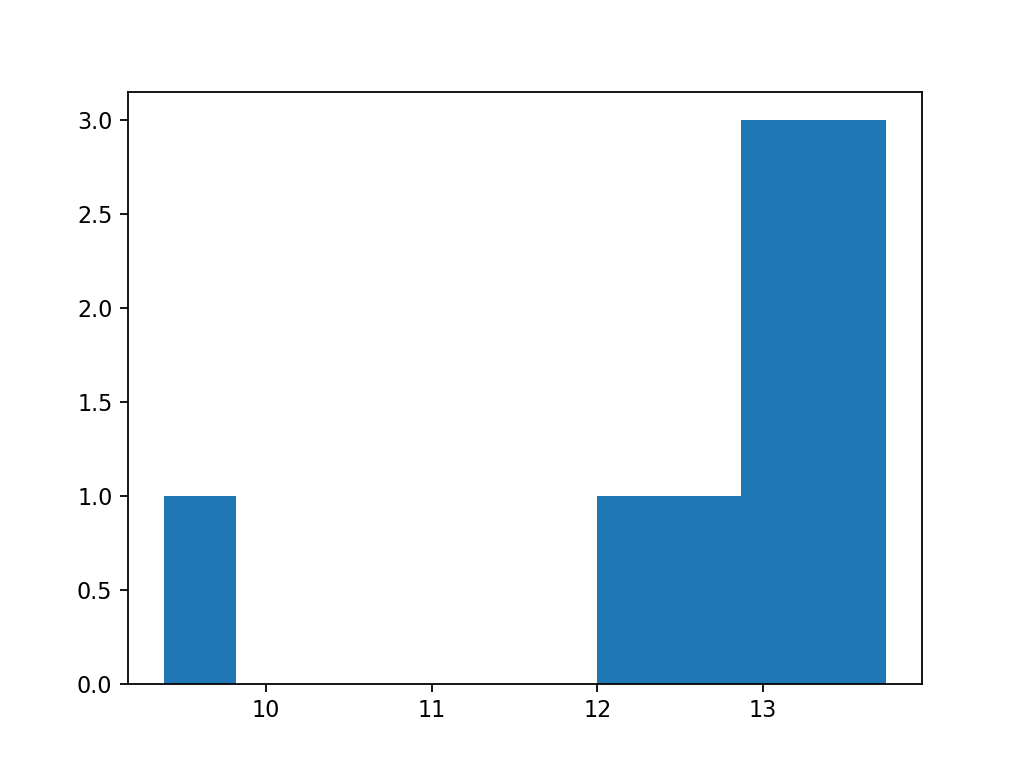

(array([1., 0., 0., 0., 0., 0., 1., 1., 3., 3.]),
 array([ 9.3829 ,  9.81875, 10.2546 , 10.69045, 11.1263 , 11.56215,
        11.998  , 12.43385, 12.8697 , 13.30555, 13.7414 ]),
 <a list of 10 Patch objects>)

In [345]:
pos, gmag = Gaia(tpf,14)
plt.figure()
plt.hist(gmag)

<IPython.core.display.Javascript object>


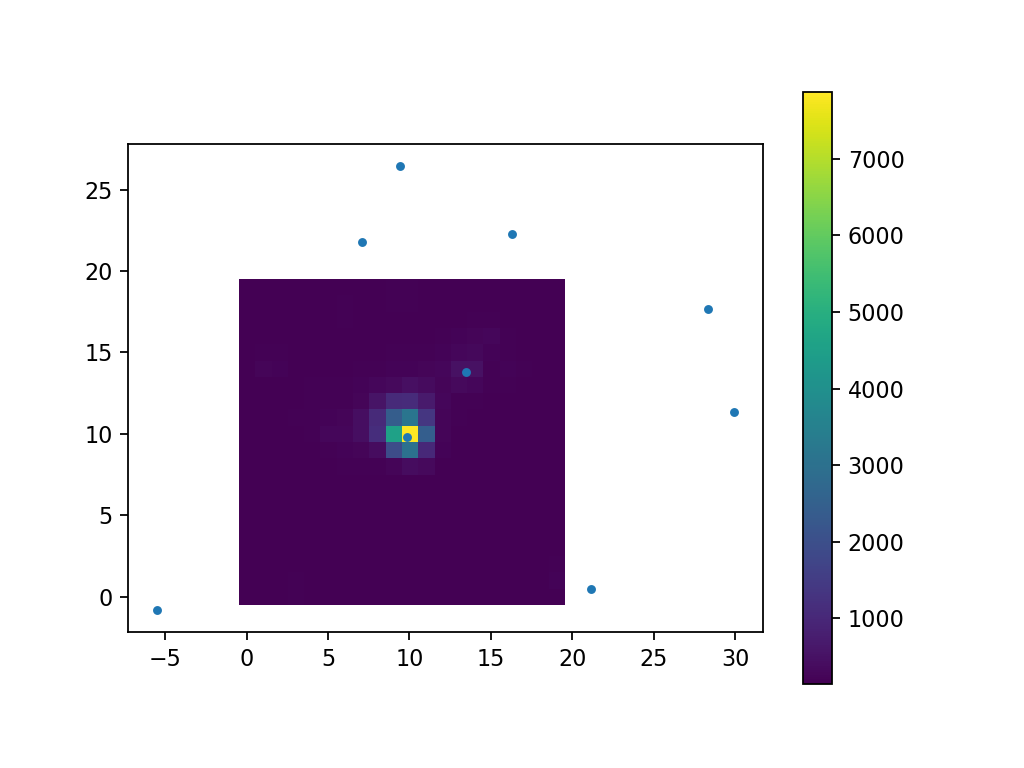

In [346]:
plt.figure()
plt.imshow(tpf.flux[100],origin='lower')
plt.colorbar()
plt.plot(pos[:,0],pos[:,1],'.')

In [347]:
scene = GAIA_scene(ra,dec,20,14)

<IPython.core.display.Javascript object>


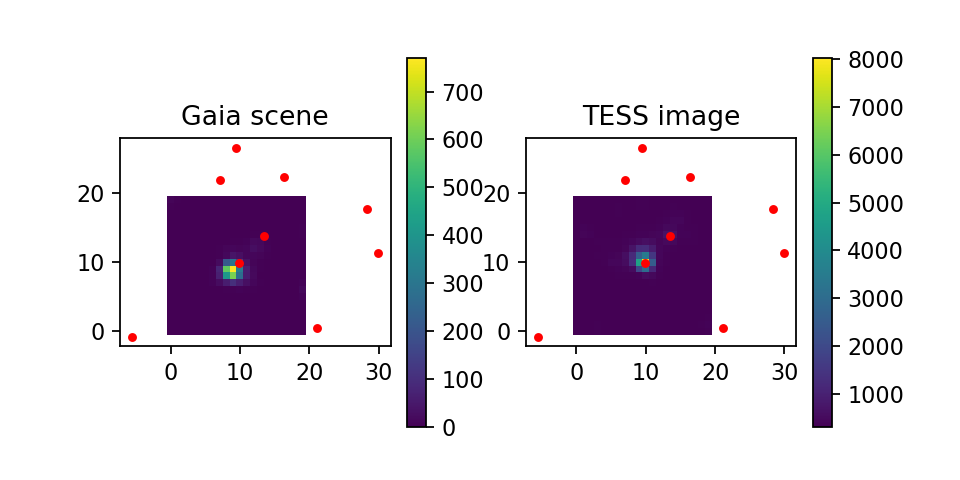

In [352]:
gaia = np.nansum(scene,axis=0)
#gaia = rotate(np.flipud(gaia*10),-90)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(gaia,origin='lower')
plt.colorbar()
plt.plot(pos[:,0],pos[:,1],'r.')
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[0],origin='lower')
plt.colorbar()
plt.plot(pos[:,0],pos[:,1],'r.')

#plt.savefig('gaia_scene.png')


<IPython.core.display.Javascript object>


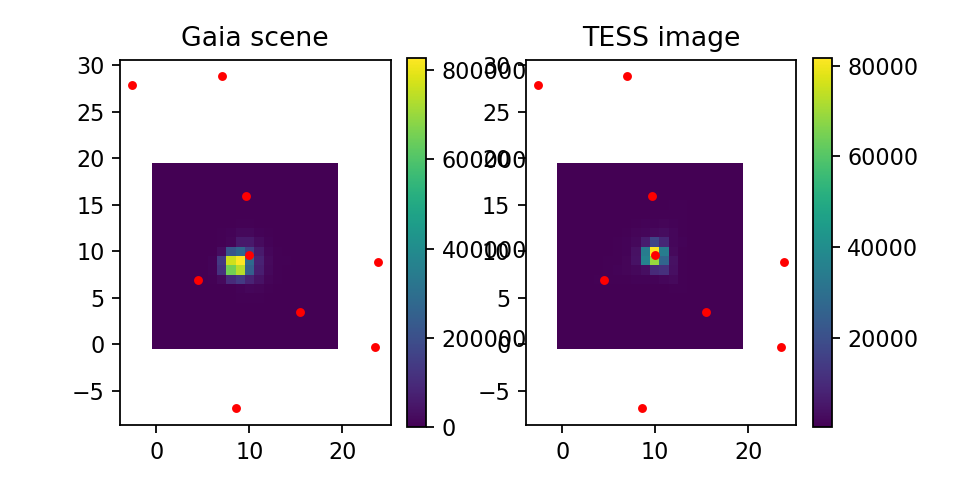

In [285]:
gaia = np.nansum(scene,axis=0)
gaia = rotate(np.flipud(gaia*10),-90)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(rotate(np.flipud(gaia*10),-90),origin='lower')
plt.colorbar()
plt.plot(pos[:,0]-1,pos[:,1]-1,'r.')
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[0],origin='lower')
plt.colorbar()
plt.plot(pos[:,0]-1,pos[:,1]-1,'r.')

#plt.savefig('gaia_scene.png')


<IPython.core.display.Javascript object>


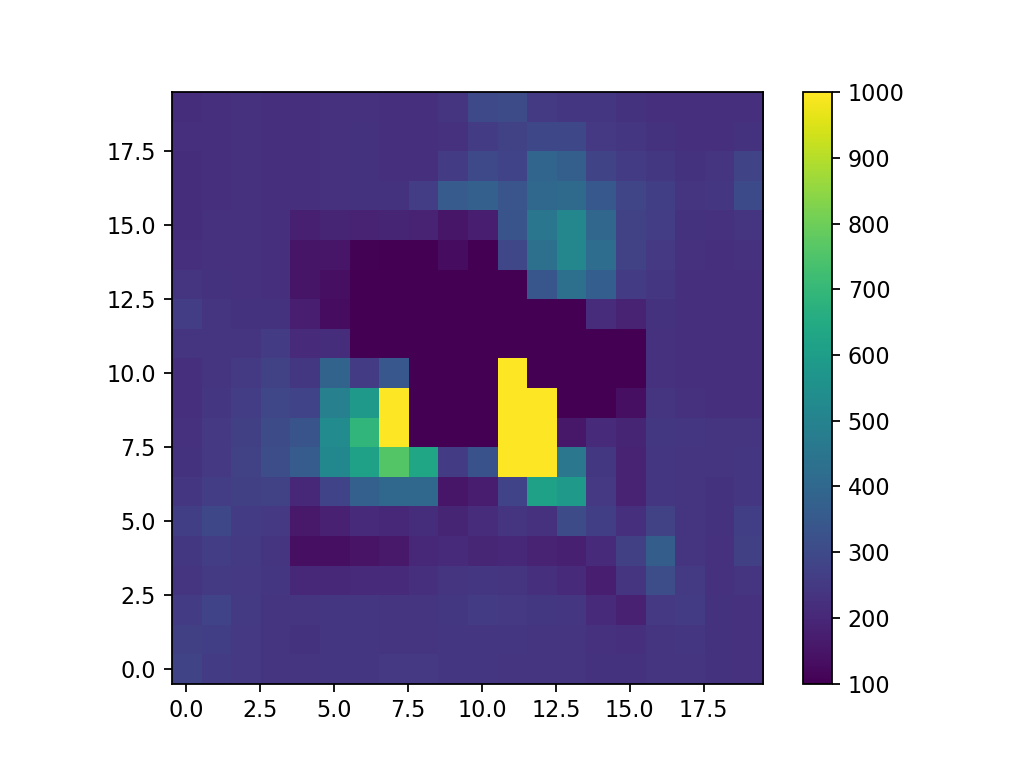

In [277]:
plt.figure()
plt.imshow(tpf.flux[0] - gaia,origin='lower',vmin=100,vmax=1000)
plt.colorbar()

In [228]:
np.power(10, -(21.5 - 25)/2.5)

25.118864315095795

In [294]:
np.where(np.nanmin(gmag)==gmag)

(array([2]),)

In [295]:
pos

array([[ 8.59202277, -6.91560726],
       [23.5668607 , -0.35671157],
       [ 9.97493887,  9.55693945],
       [ 4.52944512,  6.92608761],
       [15.48270088,  3.42402754],
       [23.866441  ,  8.84468222],
       [ 9.63404296, 15.94601467],
       [29.32716565, 15.85689731],
       [-2.58187837, 27.82753317],
       [ 7.01787435, 28.79627377]])

In [315]:
tpf.flux.shape

(1188, 20, 20)

In [500]:
#ra = 58.7404
#dec = 12.9061
Ra =  95.4586
Dec = -51.2377
Size = 20
Maglim = 14
tpf = Get_TESS(Ra,Dec,Size)
pos, gmag = Gaia(tpf,magnitude_limit=Maglim)
#pos -= 1
Tmag = gmag - 0.5
tcounts = 10**(-2/5*(Tmag - 20.44))

/Users/ryanr/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:202: LightkurveWarning: Warning: 4 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [501]:
sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2]))
for i in range(len(pos)):
    template = np.zeros((2*tpf.shape[1],2*tpf.shape[2]))
    kernal = Get_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd)
    #print(template.shape)
    offset1 = int(0.5 * tpf.shape[1])
    offset2 = int(0.5 * tpf.shape[2])
    template[int(pos[i,0] + offset1),int(pos[i,1] + offset2)] = tcounts[i]
    template = signal.fftconvolve(template, kernal, mode='same')
    template = template[offset1:int(3*offset1),offset2-1:int(3*offset2-1)]
    #plt.figure()
    #plt.imshow(template)
    sources[i] = template

<IPython.core.display.Javascript object>


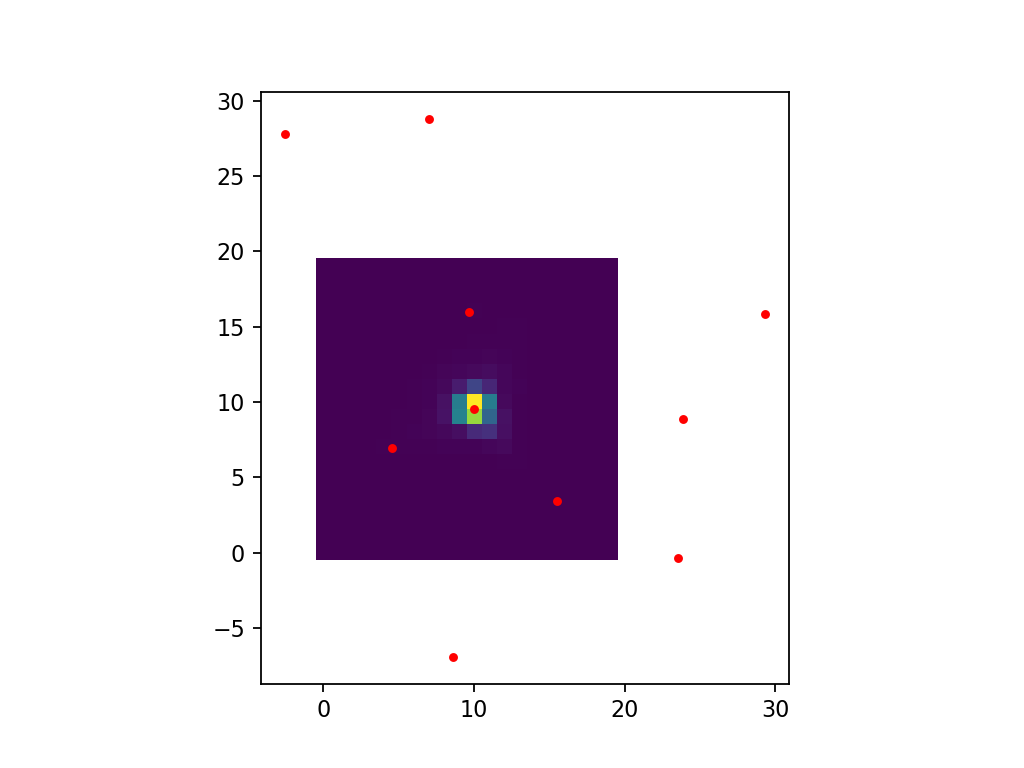

In [316]:
plt.figure()
plt.imshow(tpf.flux[0],origin='lower')
plt.plot(pos[:,0],pos[:,1],'r.')

In [450]:
i = np.where(np.nanmin(gmag) == gmag)[0][0]
template = np.zeros((2*tpf.shape[1],2*tpf.shape[2]))
kernal = Get_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd)
print(template.shape)
offset1 = int(0.5 * tpf.shape[1])
offset2 = int(0.5 * tpf.shape[2])
print(template.shape)
template[int(np.rint(pos[i,0]) + offset1),int(np.rint(pos[i,1]) + offset2)] = tcounts[i]
print(template.shape)
template = signal.fftconvolve(template, kernal, mode='same')
template = template[offset1+1:int(3*offset1+1),offset2:int(3*offset2)]
print(template.shape)

(40, 40)
(40, 40)
(40, 40)
(20, 20)


In [429]:
template.shape

(40, 40)

<IPython.core.display.Javascript object>


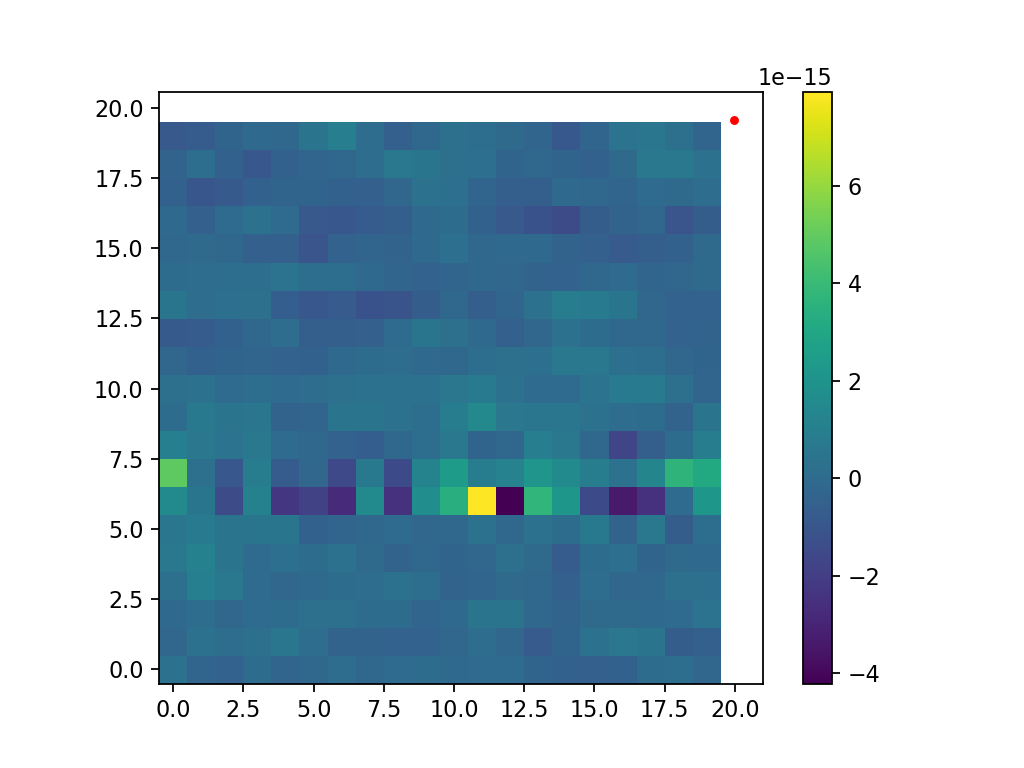

<IPython.core.display.Javascript object>


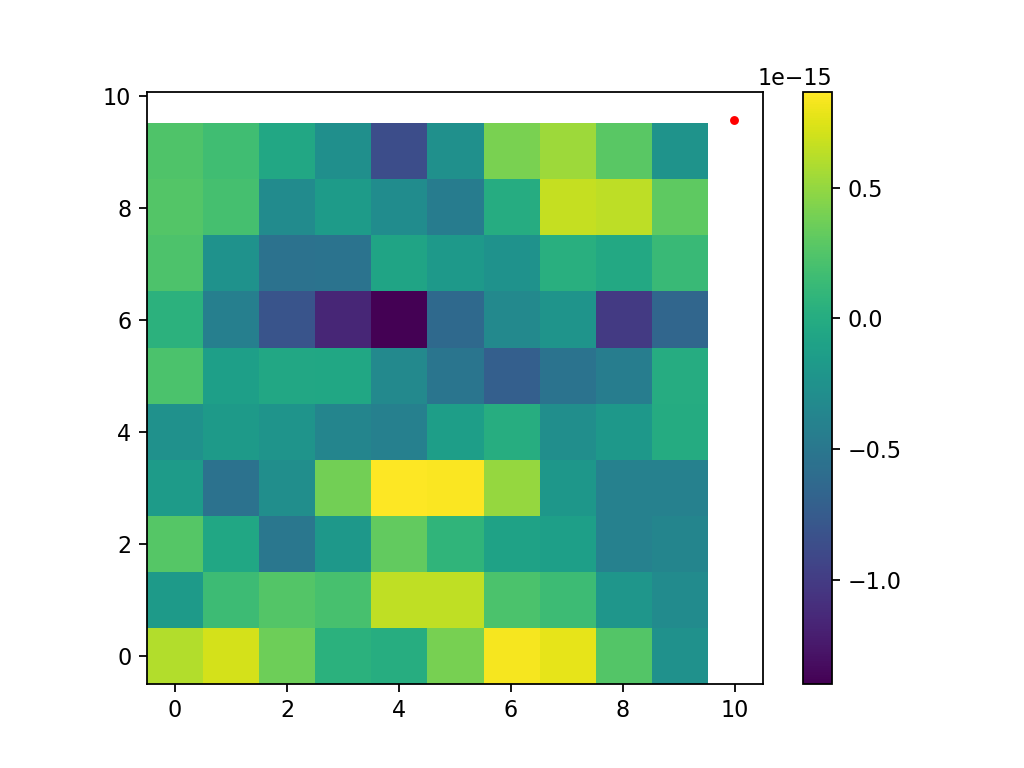

In [485]:
plt.figure()
plt.imshow(template,origin='lower')
plt.plot((pos[2,0] + offset1),(pos[2,1] + offset2),'r.')
plt.colorbar()


plt.figure()
tc = template[offset1:int(3*offset1+1),offset2:int(3*offset2+1)]
plt.imshow(tc,origin='lower')
plt.plot((pos[2,0]),(pos[2,1]),'r.')
plt.colorbar()

<IPython.core.display.Javascript object>


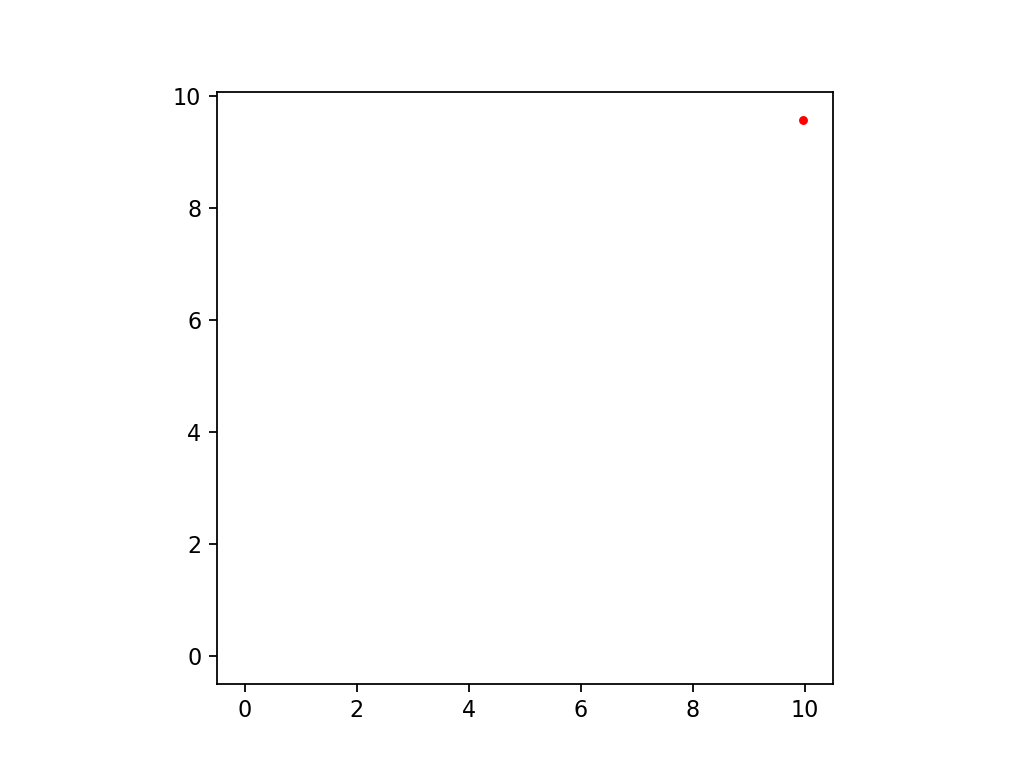

/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  
/Users/ryanr/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  


In [444]:
plt.figure()
plt.imshow(Downsample(tc),origin='lower')
plt.plot((pos[2,0]),(pos[2,1]),'r.')

<IPython.core.display.Javascript object>


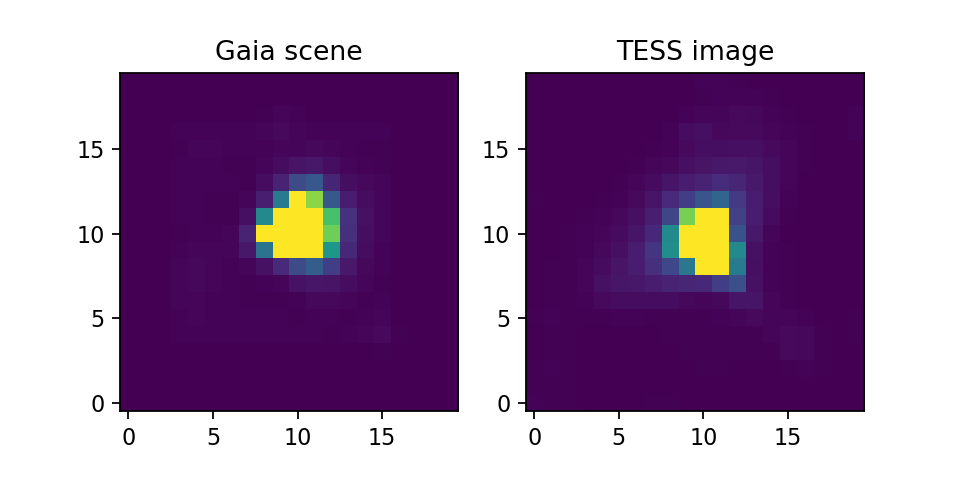

In [502]:

ga = np.nansum(sources,axis=0)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(rotate(np.flipud(ga/np.nanmax(ga)),-90),origin='lower',vmax=.1)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[0]/np.nanmax(tpf.flux[0]),origin='lower',vmax=.1)
#plt.savefig('HD44958_gaia_scene.png')

In [447]:
tc.shape

(21, 21)

<IPython.core.display.Javascript object>


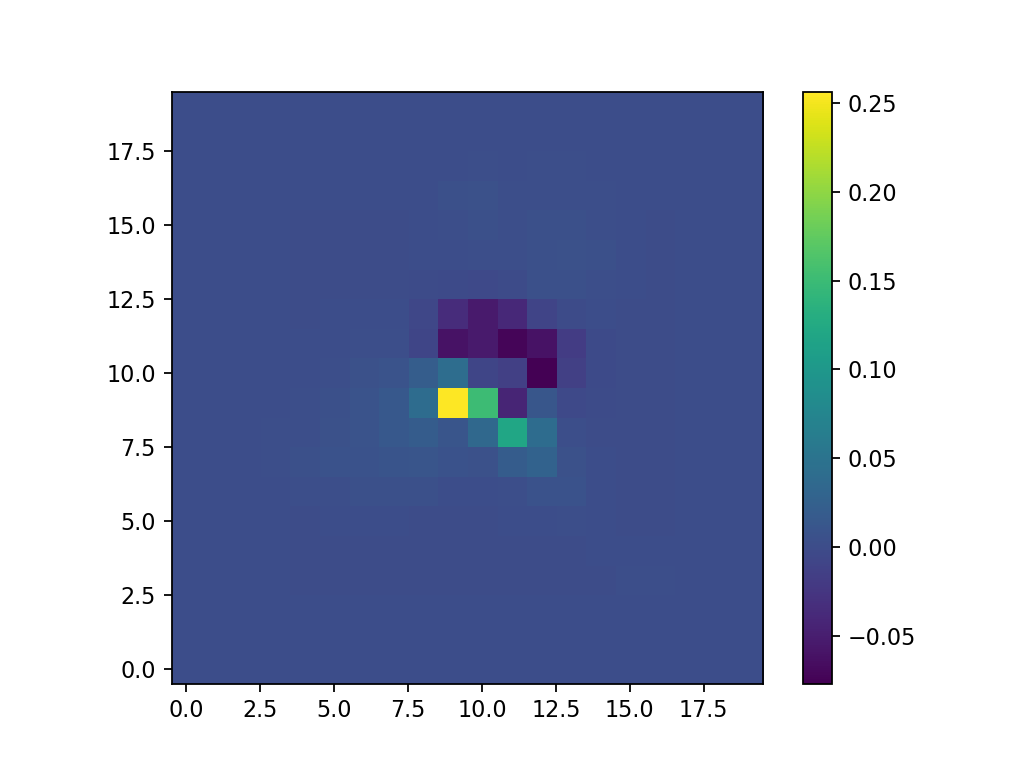

In [455]:
med = np.nanmedian(tpf.flux,axis=0)
plt.figure()
plt.imshow(med/np.nanmax(med)-template/np.nanmax(template),origin='lower')
plt.colorbar()

<IPython.core.display.Javascript object>


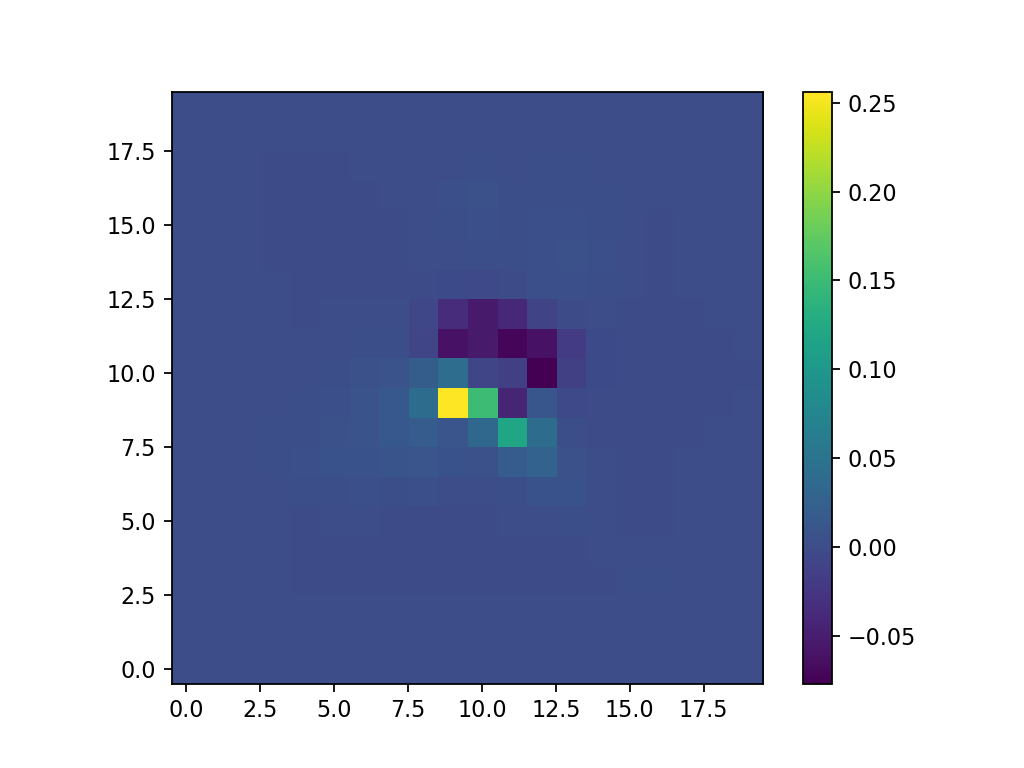

In [486]:
ga = np.nansum(sources,axis=0)
med = np.nanmedian(tpf.flux,axis=0)
plt.figure()
plt.imshow(med/np.nanmax(med)-ga/np.nanmax(ga),origin='lower')
plt.colorbar()
plt.savefig('Gaia_diff.png')

In [462]:
sources.shape

(10, 20, 20)

<IPython.core.display.Javascript object>


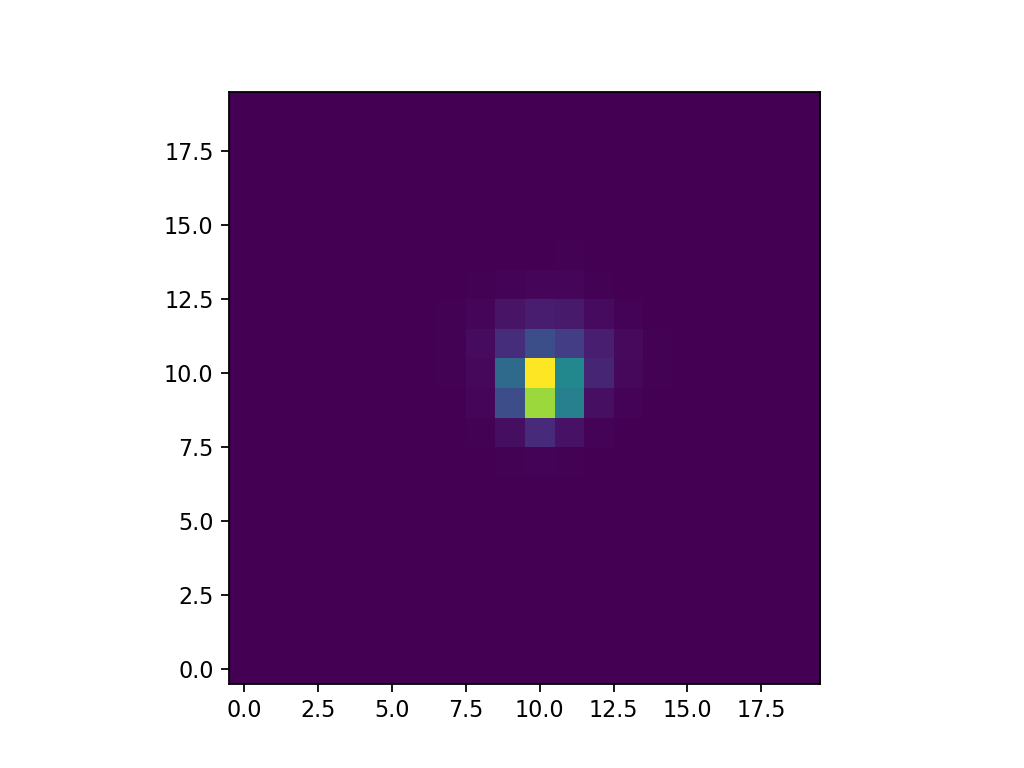

In [478]:
plt.figure()
plt.imshow(ga,origin='lower')

<IPython.core.display.Javascript object>


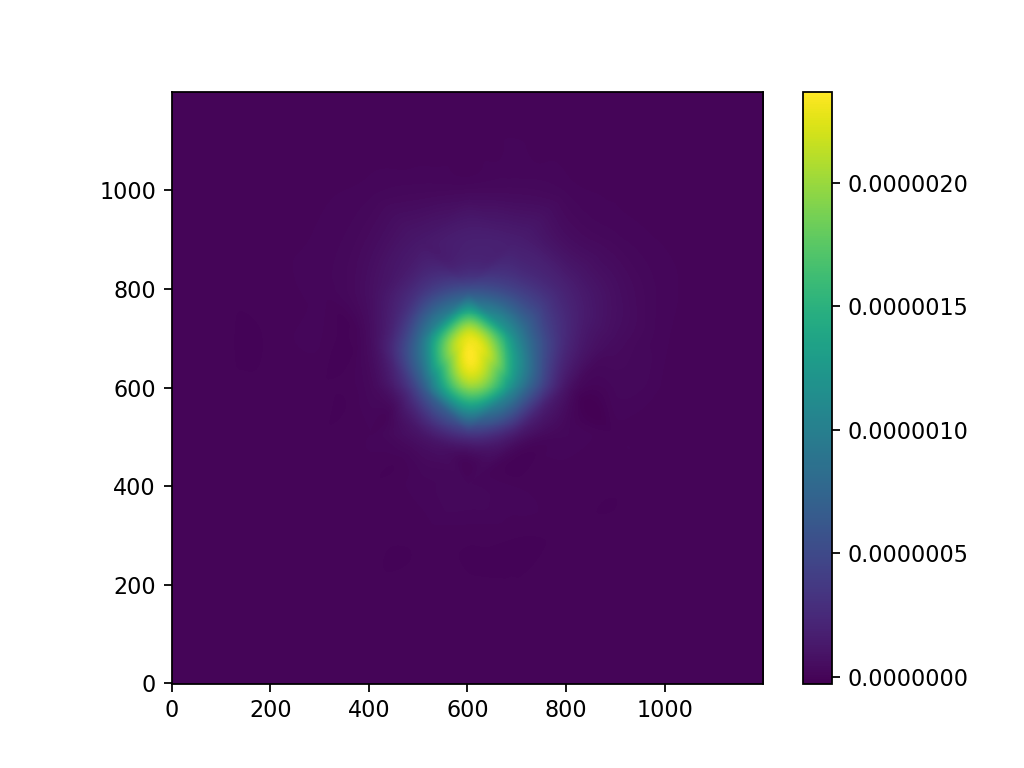

<IPython.core.display.Javascript object>


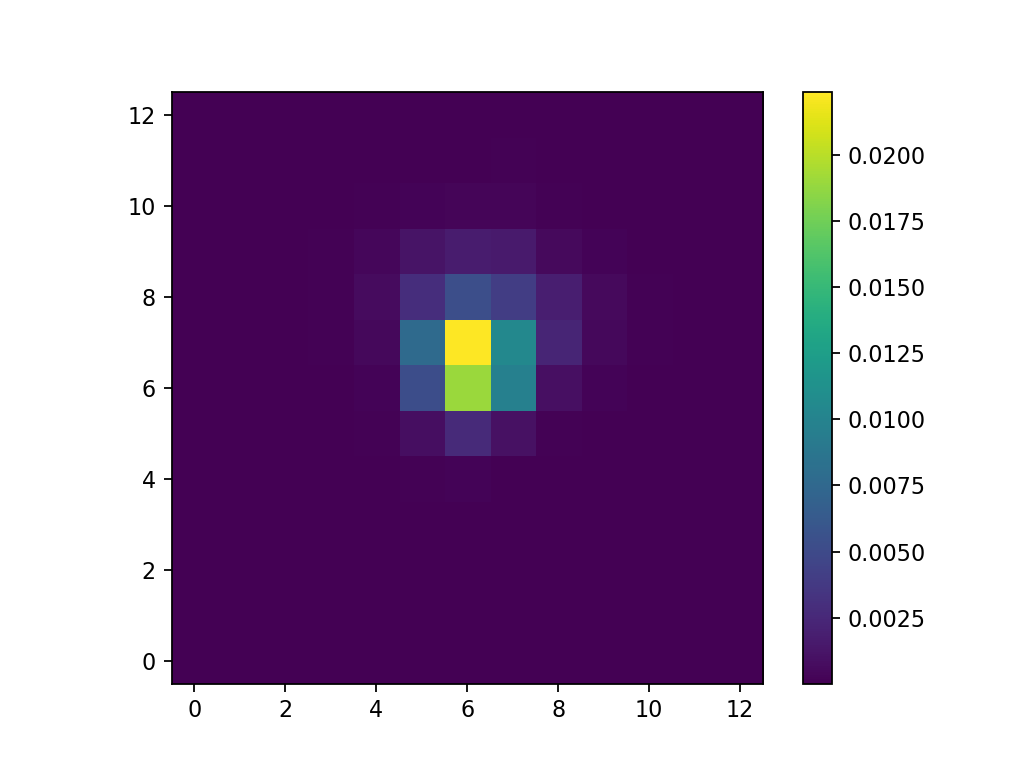

In [371]:
plt.figure()
plt.imshow(kernal,origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(Get_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd),origin='lower')
plt.colorbar()

In [337]:
norm_scene = Downsample(tc)/np.nanmax(Downsample(tc))
test = np.copy(tpf.flux)
test = test/np.nanmax(test,axis=0) - norm_scene


<IPython.core.display.Javascript object>


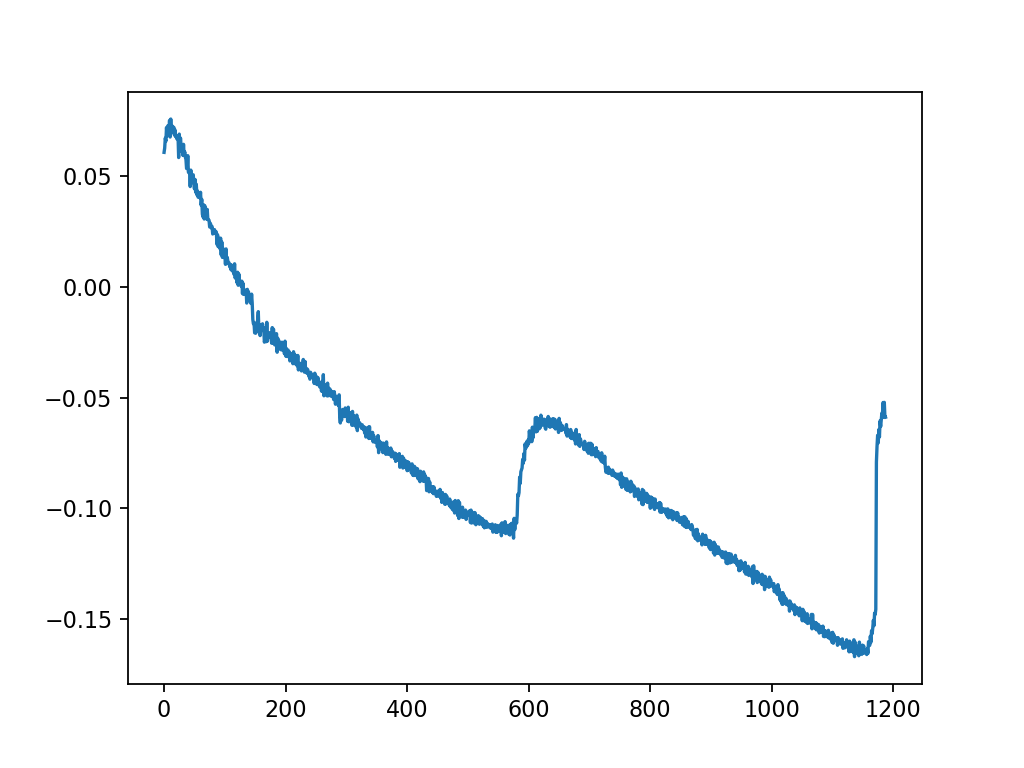

In [340]:
plt.figure()
plt.plot(test[:,10,9])

In [378]:
prf = Get_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd)

In [405]:
prf = Get_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd)
eh = np.zeros((20,20))
eh[int(np.rint(pos[i,0]))-1,int(np.rint(pos[i,1]))+1] = tcounts[i]
ehh = signal.fftconvolve(eh, prf, mode='same')

<IPython.core.display.Javascript object>


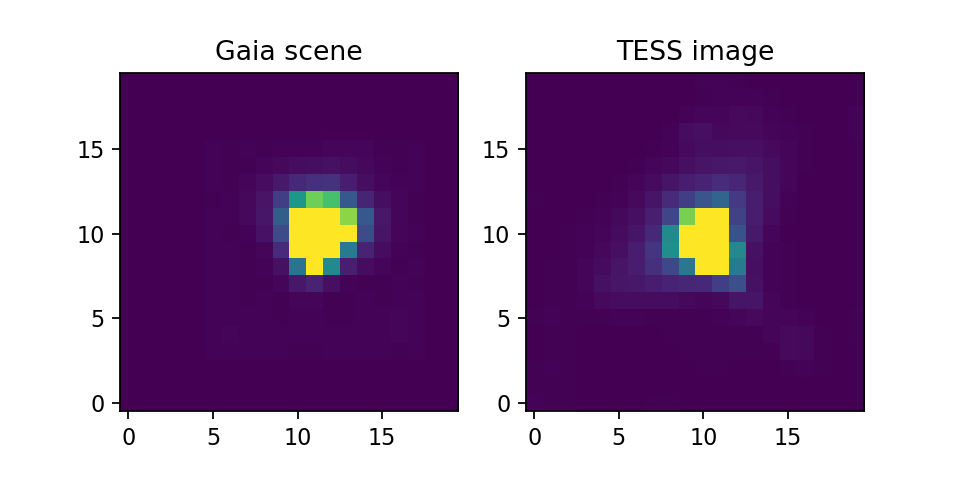

In [406]:
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title('Gaia scene')
plt.imshow(ehh/np.nanmax(ehh),origin='lower',vmax=0.1)
plt.subplot(1,2,2)
plt.title('TESS image')
plt.imshow(tpf.flux[0]/np.nanmax(tpf.flux[0]),origin='lower',vmax=0.1)

<IPython.core.display.Javascript object>


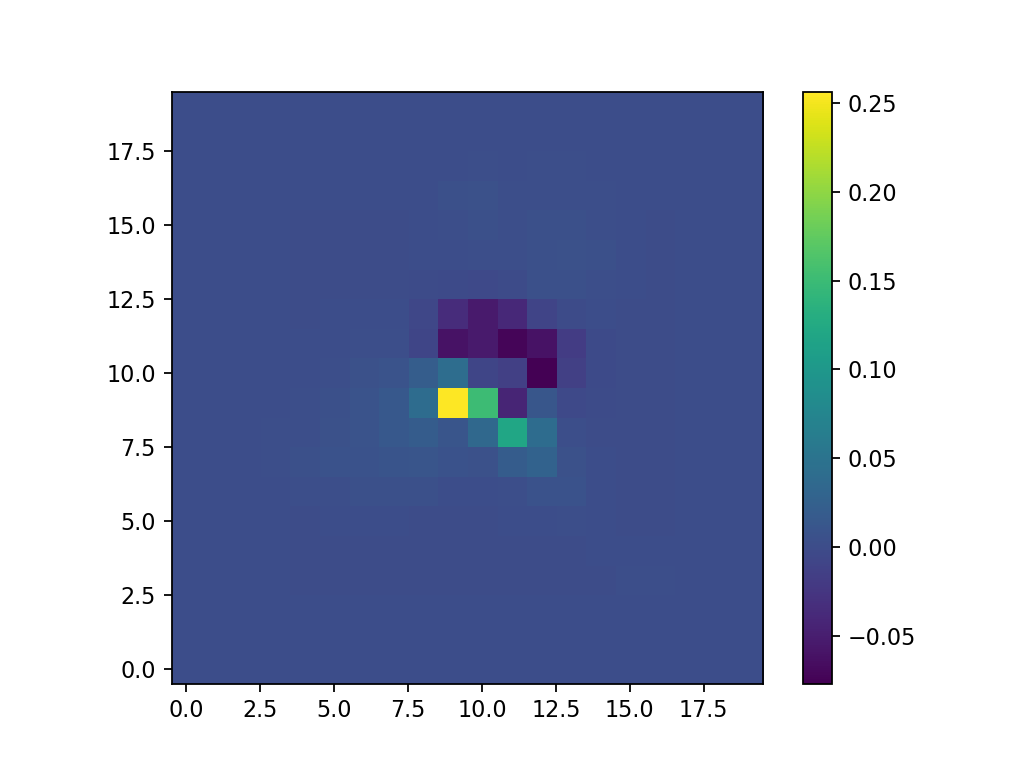

In [400]:
med = np.nanmedian(tpf.flux,axis=0)
plt.figure()
plt.imshow(med/np.nanmax(med)-ehh/np.nanmax(ehh),origin='lower')
plt.colorbar()
plt.savefig()

# Broken gaia scenes

In [424]:
def GAIA_scene(Ra,Dec,Size,Maglim=19,Interpolate=False):
    tpf = Get_TESS(Ra,Dec,Size)
    pos, gmag = Gaia(tpf,magnitude_limit=Maglim)
    pos -= 1
    Tmag = gmag - 0.5
    tcounts = 10**(-2/5*(Tmag - 20.44))
    sources = np.zeros((len(pos),tpf.shape[1],tpf.shape[2]))
    for i in range(len(pos)):
        if Interpolate:
            scale = 100
        else:
            scale = 1
        template = np.zeros((2*tpf.shape[1]*scale,2*tpf.shape[2]*scale))
        #print(template.shape)
        offset1 = int(0.5 * tpf.shape[1] * scale)
        offset2 = int(0.5 * tpf.shape[2] * scale)
        template[int(pos[i,0]*scale + offset1),int(pos[i,1]*scale+ offset2)] = tcounts[i]
        
        if Interpolate:
            kernal = Interp_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd) # check row and column are right
            template = signal.fftconvolve(template, kernal, mode='same')
            template = template[offset1:int(3*offset1+1),offset2:int(3*offset2+1)]
            sources[i] = Downsample(template)
        else:
            kernal = Get_PRF(pos[i,0] + tpf.row, pos[i,1] + tpf.column,tpf.camera,tpf.ccd)
            template[int(np.rint(pos[i,0]))-1,int(np.rint(pos[i,1]))+1] = tcounts[i]
            template = signal.fftconvolve(template, kernal, mode='same')
            #print(template.shape)
            template = template[offset1:int(3*offset1),offset2:int(3*offset2)]
            #print(template.shape)            
            sources[i] = template
    return sources 